## Сервисные фукнции

In [1]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

In [2]:
# Определим также функцию для просмотра случайных изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n):
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [3]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [4]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

In [5]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):

    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

## Подключение бибилиотек


In [6]:
# Callback ModelChekpoint для сохранения лучших весов модели
from tensorflow.keras.callbacks import ModelCheckpoint

# Основа для модели нейронной сети
from tensorflow.keras.models import Model

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# Дополнительные утилиты keras
from tensorflow.keras import utils

# Инструменты для построения графиков
import matplotlib.pyplot as plt

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# Инструменты для работы с массивами
import numpy as np

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

## Загрузка и обзор датасета

Зададим глобальные параметры:

In [7]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
CLASS_COUNT = 14           # Количество классов на изображении
TRAIN_DIRECTORY = './dataset/train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = './dataset/val'         # Название папки с файлами проверочной выборки
checkpoint_filepath = './model.h5'      # Путь до папки, где сохраняются лучшие веса модели

Загрузим входные изображения:

In [8]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'origa', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'origa', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 9.34 с
Количество изображений: 800
Проверочная выборка загружена. Время загрузки: 1.53 с
Количество изображений: 100


In [9]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 2.40 с
Количество изображений: 800
Проверочная выборка загружена. Время загрузки: 0.47 с
Количество изображений: 100


In [10]:
background = (0,0,0)
back_bumper = (251,233,1)
back_glass = (26,167,55)
back_door = (0,93,173)
back_light = (230,9,42)

front_bumper = (74,26,128)
front_glass = (237,89,17)
front_door = (150,195,32)
front_light = (149,17,127)
hood = (245,174,8)

mirror = (9,158,162)
tailgate = (196,255,14)
trunk = (255,174,200)
wheel = (240,240,240)

Объединим все в один список меток классов:

In [11]:
CLASS_LABELS = (background, back_bumper, back_glass, back_door, back_light, front_bumper, front_glass, front_door, front_light, hood, mirror, tailgate, trunk, wheel)

## Формирование выборок

In [12]:
# Формирование обучающей выборки
X_TRAIN = []                          # Cписок под обучающую выборку
for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    X_TRAIN.append(x)                 # Добавление элемента в x_train

X_TRAIN = np.array(X_TRAIN)           # Перевод всей выборки в numpy
print(X_TRAIN.shape)                  # Форма x_train


# Формирование проверочной выборки
x_val = []                            # Cписок под проверочную выборку
for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)

(800, 256, 256, 3)
(100, 256, 256, 3)


In [13]:
# Преобразование сегментов в метки классов

Y_TRAIN1 = rgb_to_labels(train_segments)
y_val1 = rgb_to_labels(val_segments)

print(Y_TRAIN1.shape)
print(y_val1.shape)

(800, 256, 256, 1)
(100, 256, 256, 1)


In [14]:
# Преобразование ответов в формат one_hot_encoding
Y_TRAIN = utils.to_categorical(Y_TRAIN1, CLASS_COUNT)
y_val = utils.to_categorical(y_val1, CLASS_COUNT)

In [15]:
print(Y_TRAIN.shape)
print(y_val.shape)

(800, 256, 256, 14)
(100, 256, 256, 14)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_TRAIN,
                                                    Y_TRAIN,
                                                    test_size = 0.07,
                                                    shuffle=True,
                                                    random_state=42)

print('Обучающая выборка изображений', len(x_train))
print('Обучающая выборка масок', len(y_train))
print()
print('Тестовая выборка изображений', len(x_test))
print('Тестовая выборка масок', len(y_test))

Обучающая выборка изображений 743
Обучающая выборка масок 743

Тестовая выборка изображений 57
Тестовая выборка масок 57


## Осмотр объема классов в пиксельном эквиваленте

In [17]:
# Вычисление количества пикселов по всем классам в y_train
pix_count = np.zeros(CLASS_COUNT)
for i in range(CLASS_COUNT):
    pix_count[i] = (Y_TRAIN1 == i).sum()

for count, elem in enumerate(pix_count):
  print (count, elem)

0 31333981.0
1 1617734.0
2 6032393.0
3 1527290.0
4 295037.0
5 711905.0
6 1966844.0
7 1993809.0
8 660096.0
9 1240223.0
10 236676.0
11 899422.0
12 2328252.0
13 1585138.0


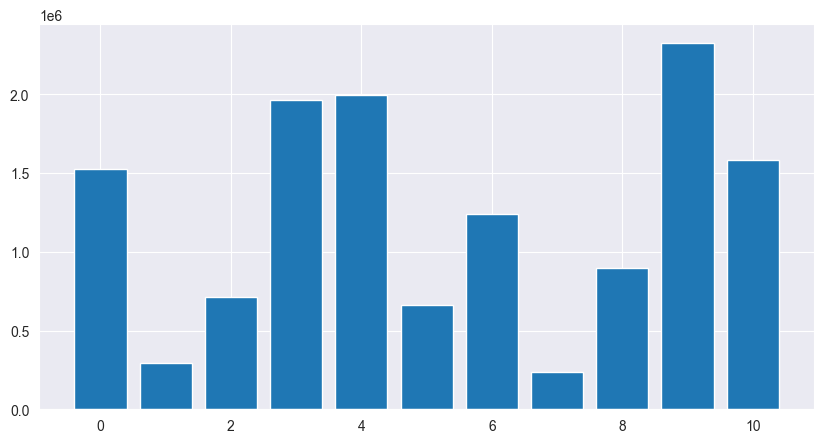

In [18]:
# Отрисовка столбчатой диаграммы наполненности классов
plt.figure(figsize = (10, 5))
plt.bar(np.arange(CLASS_COUNT-3), pix_count[3:])
plt.show()

## Создание U-net модели


In [19]:
from segmentation_models.metrics import IOUScore
metric = IOUScore()

Segmentation Models: using `keras` framework.


In [20]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D


    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_4_out)                                         # Добавляем слой MaxPooling2D


    ''' Block 5 '''
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_5_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_5_out


    ''' UP 1 '''
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_4_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(512, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation


    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[metric])

    # Возвращаем сформированную модель
    return model

In [21]:
# Создание расширенной модели и вывод сводки

model_masked_unet = masked_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT,3))

In [22]:
model_masked_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

                                                                                                  
 batch_normalization_15 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_1[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 32, 32, 512)  0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 256)  524544     ['activation_15[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_16 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_transpose_1[0][0]']     
 ormalizat

In [23]:
utils.plot_model(model_masked_unet, dpi=80)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Запуск модели

In [24]:
# Создание callback для сохранения лучших весов модели

model_checkpoint_callback = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_iou_score',
                                mode='max',
                                save_best_only=True)

In [ ]:
# Обучение модели

history = model_masked_unet.fit(x_train, y_train,
                                epochs=145,
                                batch_size=20,
                                validation_data=(x_test, y_test),
                                callbacks=[model_checkpoint_callback])

Максимальная точность при обучени на тестовых данных:  0.7752770781517029


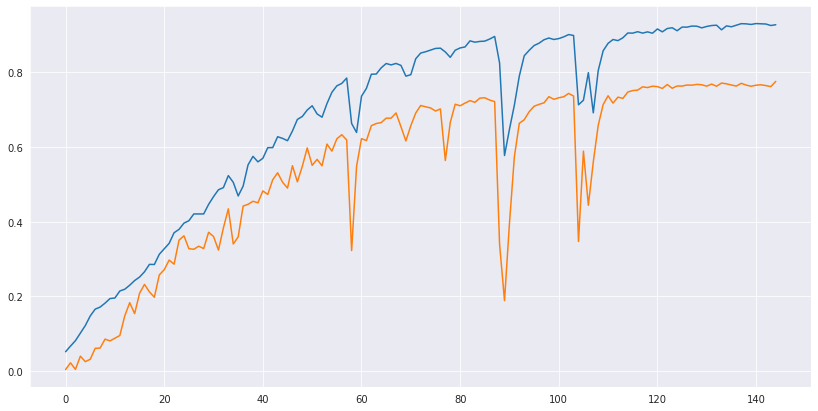

In [ ]:
print('Максимальная точность при обучени на тестовых данных: ', max(history.history['val_iou_score']))

# Отображение графиков обучения модели
plt.figure(figsize=(14, 7))
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.show()